In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import random

import cv2
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import plot_model

In [2]:
# Define base directory and target split ratios
base_dir = '/kaggle/input/celeb-df-new/Celeb-DF-New'
output_dir = '/kaggle/working/split_data'
split_ratios = {'train': 0.5, 'valid': 0.2, 'test': 0.3}

# Create output directories
for split in split_ratios.keys():
    for label in ['Real', 'Fake']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)

# Function to split and copy images
def split_images(label, label_dir):
    # Get all images in the label directory
    images = os.listdir(label_dir)
    random.shuffle(images)  # Shuffle images

    # Calculate split sizes
    total_images = len(images)
    train_size = int(split_ratios['train'] * total_images)
    valid_size = int(split_ratios['valid'] * total_images)

    # Split images
    train_images = images[:train_size]
    valid_images = images[train_size:train_size + valid_size]
    test_images = images[train_size + valid_size:]

    # Function to copy files to output directory
    def copy_images(image_list, split):
        for img in image_list:
            src = os.path.join(label_dir, img)
            dest = os.path.join(output_dir, split, label, img)
            shutil.copy(src, dest)

    # Copy images to respective directories
    copy_images(train_images, 'train')
    copy_images(valid_images, 'valid')
    copy_images(test_images, 'test')

# Split and copy images for both labels
for label in ['Real', 'Fake']:
    label_dir = os.path.join(base_dir, label)
    split_images(label, label_dir)

print("Images have been split and saved to:", output_dir)

Images have been split and saved to: /kaggle/working/split_data


In [3]:
import os
import shutil

# Define the base directories
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
second_main_path = '/kaggle/input/deepfake-and-real-images/Dataset'
third_main_path = '/kaggle/working/split_data'  # Celeb-DF-New after splitting

# Dataset name mappings
dataset_names = ['140K', 'Deepfake', 'Celeb-DF-New']

# Subdirectories for train, valid, and test
sub_dirs_mapping = {
    'train': ['train', 'Train', 'train'],
    'valid': ['valid', 'Validation', 'valid'],
    'test': ['test', 'Test', 'test']
}

# Label mapping for real and fake folders
label_mapping = {'Real': 1, 'Fake': 0, 'real': 1, 'fake': 0}

# Create directories for each dataset
for dataset_name in dataset_names:
    for split_key, sub_dirs in sub_dirs_mapping.items():
        split_folder = os.path.join(third_main_path, dataset_name, split_key)
        
        # Create split folder for each dataset (train, valid, test)
        if not os.path.exists(split_folder):
            os.makedirs(split_folder)

        # Process respective dataset based on the split
        if dataset_name == '140K':
            base_path = main_path
            sub_dir = sub_dirs[0]
        elif dataset_name == 'Deepfake':
            base_path = second_main_path
            sub_dir = sub_dirs[1]
        else:  # Celeb-DF-New
            base_path = third_main_path
            sub_dir = sub_dirs[2]

        # Create subfolders for 'Real' and 'Fake'
        for label_name in ['Real', 'Fake']:
            label_folder = os.path.join(split_folder, label_name)
            if not os.path.exists(label_folder):
                os.makedirs(label_folder)

            # Move the images to the correct folder
            folder_path = os.path.join(base_path, sub_dir, label_name)
            if os.path.exists(folder_path):  # Ensure folder exists
                for img_file in os.listdir(folder_path):
                    if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):  # Process image files
                        src_img_path = os.path.join(folder_path, img_file)
                        dest_img_path = os.path.join(label_folder, img_file)
                        shutil.copy(src_img_path, dest_img_path)

        print(f"Processed and moved images for {dataset_name} - {split_key}")


Processed and moved images for 140K - train
Processed and moved images for 140K - valid
Processed and moved images for 140K - test
Processed and moved images for Deepfake - train
Processed and moved images for Deepfake - valid
Processed and moved images for Deepfake - test
Processed and moved images for Celeb-DF-New - train
Processed and moved images for Celeb-DF-New - valid
Processed and moved images for Celeb-DF-New - test


## cnn

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 611s 138ms/step - accuracy: 0.6156 - loss: 0.6480 - val_accuracy: 0.7551 - val_loss: 0.5192
Epoch 2/10
   1/4375 ━━━━━━━━━━━━━━━━━━━━ 49s 11ms/step - accuracy: 0.7500 - loss: 0.5577

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1s 136us/step - accuracy: 0.7500 - loss: 0.5577 - val_accuracy: 0.7500 - val_loss: 0.3487
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 597s 136ms/step - accuracy: 0.7258 - loss: 0.5485 - val_accuracy: 0.7221 - val_loss: 0.5406
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8125 - loss: 0.4245 - val_accuracy: 1.0000 - val_loss: 0.3264
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 591s 135ms/step - accuracy: 0.7814 - loss: 0.4703 - val_accuracy: 0.7318 - val_loss: 0.5768
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8125 - loss: 0.3986 - val_accuracy: 0.7500 - val_loss: 0.5411
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 594s 136ms/step - accuracy: 0.8231 - loss: 0.4013 - val_accuracy: 0.8416 - val_loss: 0.3747
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8438 - loss: 0.3968 - val_accuracy: 1.0000 - val_loss: 0.0127
Epoch 9/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 579s 132ms/step - accuracy: 0.8539 - loss: 0.

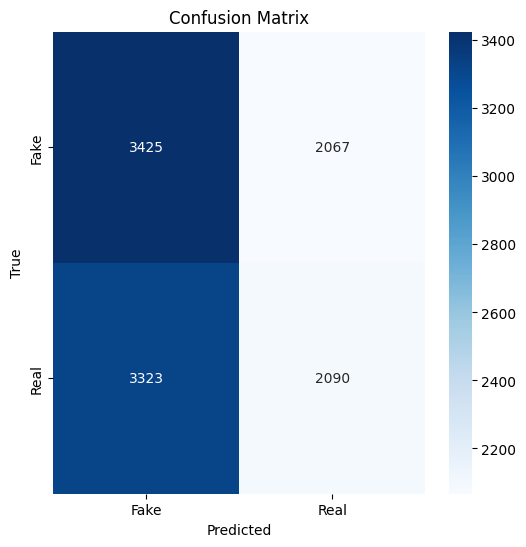

Classification Report:
              precision    recall  f1-score   support

        Fake       0.51      0.62      0.56      5492
        Real       0.50      0.39      0.44      5413

    accuracy                           0.51     10905
   macro avg       0.51      0.50      0.50     10905
weighted avg       0.51      0.51      0.50     10905



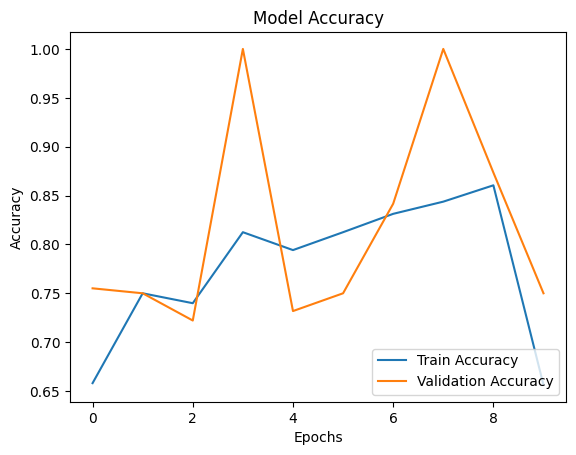

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/Deepfake/train'
valid_dir = '/kaggle/working/split_data/Deepfake/valid'
test_dir = '/kaggle/working/split_data/Deepfake/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/cnn_model.h5')


## VGG16

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 589s 133ms/step - accuracy: 0.7004 - loss: 0.5632 - val_accuracy: 0.7462 - val_loss: 0.4996
Epoch 2/15
   1/4375 ━━━━━━━━━━━━━━━━━━━━ 1:41 23ms/step - accuracy: 0.7812 - loss: 0.4375

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 1s 299us/step - accuracy: 0.7812 - loss: 0.4375 - val_accuracy: 1.0000 - val_loss: 0.4443
Epoch 3/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 589s 134ms/step - accuracy: 0.7478 - loss: 0.5003 - val_accuracy: 0.7557 - val_loss: 0.4850
Epoch 4/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.5938 - loss: 0.5909 - val_accuracy: 1.0000 - val_loss: 0.2426
Epoch 5/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 591s 135ms/step - accuracy: 0.7554 - loss: 0.4919 - val_accuracy: 0.7602 - val_loss: 0.4806
Epoch 6/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.7812 - loss: 0.4024 - val_accuracy: 0.7500 - val_loss: 0.5644
Epoch 7/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 588s 134ms/step - accuracy: 0.7578 - loss: 0.4872 - val_accuracy: 0.7661 - val_loss: 0.4732
Epoch 8/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8438 - loss: 0.3667 - val_accuracy: 1.0000 - val_loss: 0.2569
Epoch 9/15
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 586s 134ms/step - accuracy: 0.7622 - loss: 0.

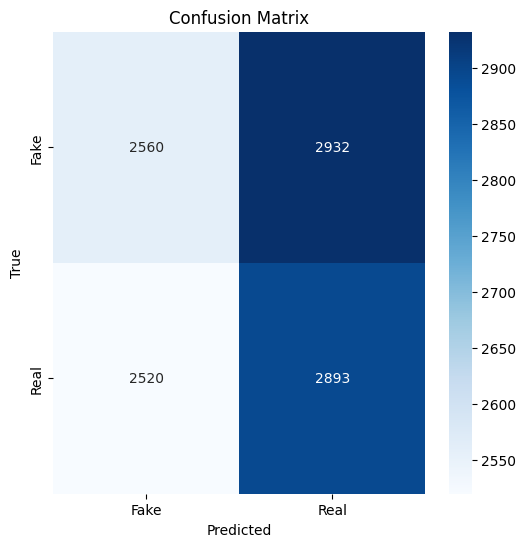

Classification Report:
              precision    recall  f1-score   support

        Fake       0.50      0.47      0.48      5492
        Real       0.50      0.53      0.51      5413

    accuracy                           0.50     10905
   macro avg       0.50      0.50      0.50     10905
weighted avg       0.50      0.50      0.50     10905



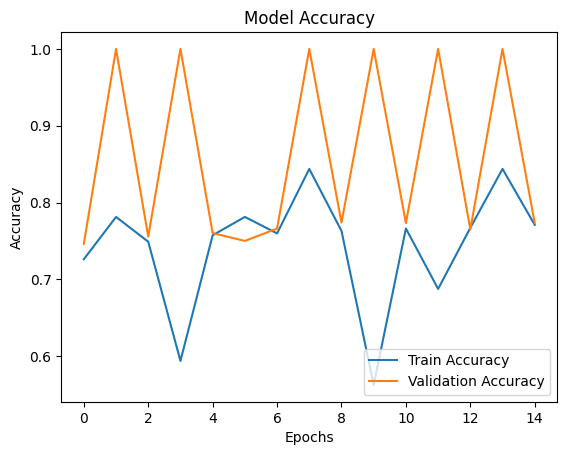

In [5]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/Deepfake/train'
valid_dir = '/kaggle/working/split_data/Deepfake/valid'
test_dir = '/kaggle/working/split_data/Deepfake/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# VGG16 model architecture with pre-trained weights from ImageNet
base_model = VGG16(
    weights='imagenet',  # Load pre-trained weights
    include_top=False,   # Exclude the final fully connected layers
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Input shape for images
)

# Freeze the convolutional layers of VGG16 (optional if you want to fine-tune)
for layer in base_model.layers:
    layer.trainable = False

# Create the custom model by adding classification layers on top of VGG16
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/vgg16_model.h5')


## ResNet50

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 619s 139ms/step - accuracy: 0.5397 - loss: 0.6900 - val_accuracy: 0.5946 - val_loss: 0.6734
Epoch 2/10
   1/4375 ━━━━━━━━━━━━━━━━━━━━ 1:29 21ms/step - accuracy: 0.4375 - loss: 0.7268

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.4375 - loss: 0.7268 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 605s 138ms/step - accuracy: 0.5786 - loss: 0.6761 - val_accuracy: 0.6151 - val_loss: 0.6612
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6250 - loss: 0.6432 - val_accuracy: 0.7500 - val_loss: 0.6394
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 606s 138ms/step - accuracy: 0.5863 - loss: 0.6719 - val_accuracy: 0.6094 - val_loss: 0.6554
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6250 - loss: 0.6362 - val_accuracy: 0.5000 - val_loss: 0.7155
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 598s 136ms/step - accuracy: 0.5894 - loss: 0.6690 - val_accuracy: 0.6313 - val_loss: 0.6473
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.6562 - loss: 0.6405 - val_accuracy: 0.5000 - val_loss: 0.6564
Epoch 9/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 612s 140ms/step - accuracy: 0.5971 - loss: 0.

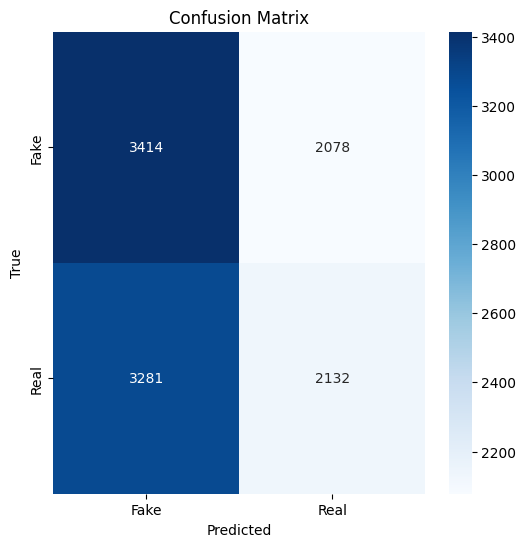

Classification Report:
              precision    recall  f1-score   support

        Fake       0.51      0.62      0.56      5492
        Real       0.51      0.39      0.44      5413

    accuracy                           0.51     10905
   macro avg       0.51      0.51      0.50     10905
weighted avg       0.51      0.51      0.50     10905



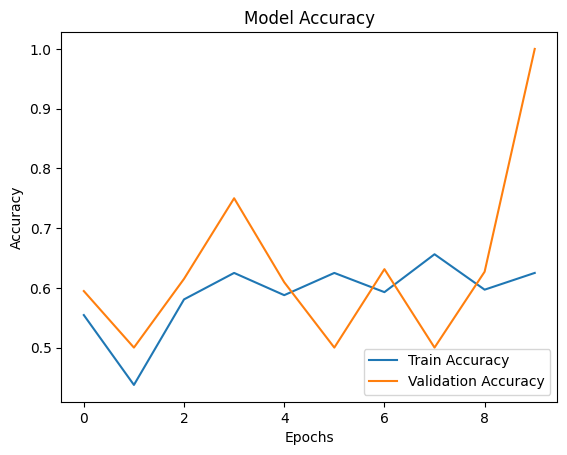

In [6]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/Deepfake/train'
valid_dir = '/kaggle/working/split_data/Deepfake/valid'
test_dir = '/kaggle/working/split_data/Deepfake/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# ResNet50 model architecture with pre-trained weights from ImageNet
base_model = ResNet50(
    weights='imagenet',  # Load pre-trained weights
    include_top=False,   # Exclude the final fully connected layers
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Input shape for images
)

# Freeze the convolutional layers of ResNet50 (optional if you want to fine-tune)
for layer in base_model.layers:
    layer.trainable = False

# Create the custom model by adding classification layers on top of ResNet50
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/resnet50_model.h5')


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 621s 140ms/step - accuracy: 0.7051 - loss: 0.5632 - val_accuracy: 0.7643 - val_loss: 0.4817
Epoch 2/10
   1/4375 ━━━━━━━━━━━━━━━━━━━━ 51s 12ms/step - accuracy: 0.8438 - loss: 0.2994

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4375/4375 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step - accuracy: 0.8438 - loss: 0.2994 - val_accuracy: 0.5000 - val_loss: 0.5164
Epoch 3/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 595s 136ms/step - accuracy: 0.7626 - loss: 0.4803 - val_accuracy: 0.7694 - val_loss: 0.4750
Epoch 4/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.7500 - loss: 0.4691 - val_accuracy: 0.2500 - val_loss: 0.8424
Epoch 5/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 593s 135ms/step - accuracy: 0.7741 - loss: 0.4660 - val_accuracy: 0.7748 - val_loss: 0.4645
Epoch 6/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.6875 - loss: 0.5467 - val_accuracy: 0.7500 - val_loss: 0.3904
Epoch 7/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 589s 134ms/step - accuracy: 0.7784 - loss: 0.4589 - val_accuracy: 0.7886 - val_loss: 0.4469
Epoch 8/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.8750 - loss: 0.3228 - val_accuracy: 0.7500 - val_loss: 0.4414
Epoch 9/10
4375/4375 ━━━━━━━━━━━━━━━━━━━━ 585s 133ms/step - accuracy: 0.7817 - loss: 0.

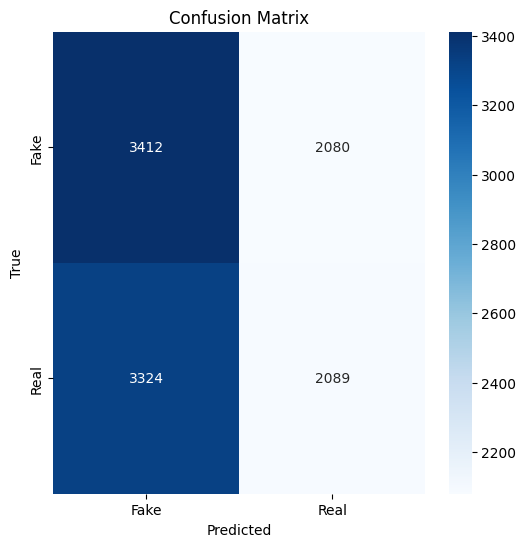

Classification Report:
              precision    recall  f1-score   support

        Fake       0.51      0.62      0.56      5492
        Real       0.50      0.39      0.44      5413

    accuracy                           0.50     10905
   macro avg       0.50      0.50      0.50     10905
weighted avg       0.50      0.50      0.50     10905



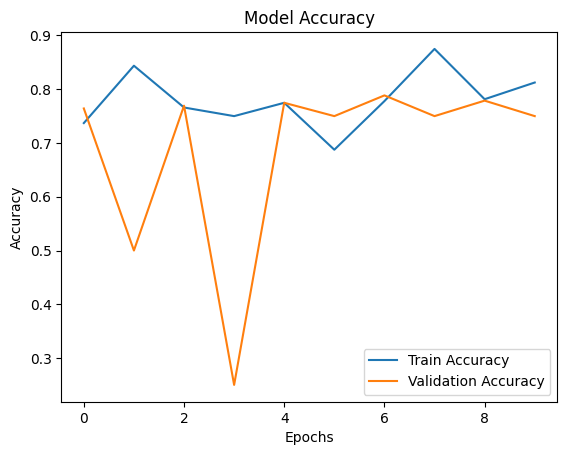

In [7]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/Deepfake/train'
valid_dir = '/kaggle/working/split_data/Deepfake/valid'
test_dir = '/kaggle/working/split_data/Deepfake/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# MobileNetV2 model architecture with pre-trained weights from ImageNet
base_model = MobileNetV2(
    weights='imagenet',  # Load pre-trained weights from ImageNet
    include_top=False,   # Exclude the final fully connected layers
    input_shape=(IMG_SIZE, IMG_SIZE, 3)  # Input shape for images
)

# Freeze the convolutional layers of MobileNetV2 (optional if you want to fine-tune)
for layer in base_model.layers:
    layer.trainable = False

# Create the custom model by adding classification layers on top of MobileNetV2
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Apply global average pooling
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/mobilenetv2_model.h5')


## /kaggle/working/split_data

## CNN

Found 15632 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.
Found 9382 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 68s 132ms/step - accuracy: 0.7231 - loss: 0.4734 - val_accuracy: 0.8774 - val_loss: 0.3410
Epoch 2/10
  1/488 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8125 - loss: 0.3779

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8125 - loss: 0.3779 - val_accuracy: 0.8333 - val_loss: 0.3844
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 63s 127ms/step - accuracy: 0.8252 - loss: 0.3548 - val_accuracy: 0.9032 - val_loss: 0.2506
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.9062 - loss: 0.2030 - val_accuracy: 0.9167 - val_loss: 0.1666
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.8546 - loss: 0.3121 - val_accuracy: 0.9212 - val_loss: 0.2184
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.8438 - loss: 0.3380 - val_accuracy: 0.9167 - val_loss: 0.2968
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 63s 128ms/step - accuracy: 0.8705 - loss: 0.2935 - val_accuracy: 0.9300 - val_loss: 0.1762
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 26us/step - accuracy: 0.8125 - loss: 0.3602 - val_accuracy: 0.9167 - val_loss: 0.1320
Epoch 9/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 63s 128ms/step - accuracy: 0.8769 - loss: 0.2785 - val_accuracy

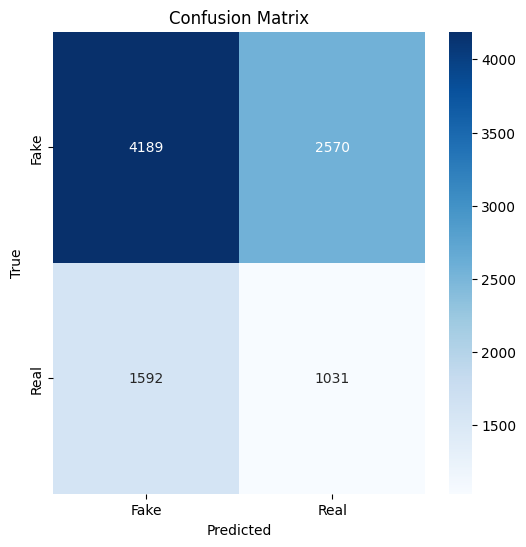

Classification Report:
              precision    recall  f1-score   support

        Fake       0.72      0.62      0.67      6759
        Real       0.29      0.39      0.33      2623

    accuracy                           0.56      9382
   macro avg       0.51      0.51      0.50      9382
weighted avg       0.60      0.56      0.57      9382



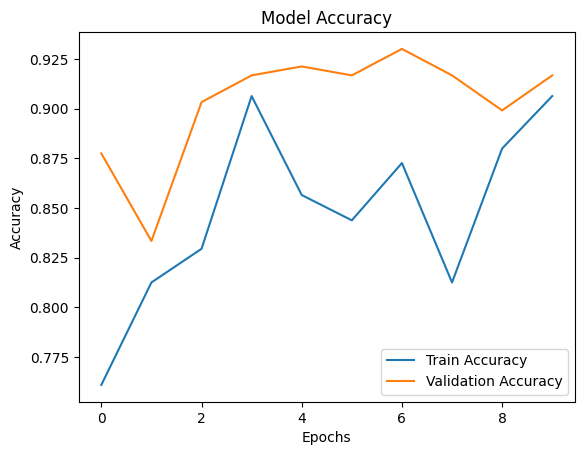

In [8]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/train'
valid_dir = '/kaggle/working/split_data/valid'
test_dir = '/kaggle/working/split_data/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/split_cnn_model.h5')


## ResNet50

Found 15632 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.
Found 9382 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 79s 142ms/step - accuracy: 0.6768 - loss: 0.6330 - val_accuracy: 0.7204 - val_loss: 0.5815
Epoch 2/10
  1/488 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.7500 - loss: 0.5961

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7500 - loss: 0.5961 - val_accuracy: 0.8333 - val_loss: 0.4966
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - accuracy: 0.7161 - loss: 0.5951 - val_accuracy: 0.7205 - val_loss: 0.5672
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.5625 - loss: 0.7840 - val_accuracy: 0.8333 - val_loss: 0.4686
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 65s 130ms/step - accuracy: 0.7211 - loss: 0.5773 - val_accuracy: 0.7231 - val_loss: 0.5522
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 57us/step - accuracy: 0.8750 - loss: 0.4284 - val_accuracy: 0.5833 - val_loss: 0.6707
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.7235 - loss: 0.5657 - val_accuracy: 0.7277 - val_loss: 0.5364
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.6875 - loss: 0.6075 - val_accuracy: 0.9167 - val_loss: 0.3772
Epoch 9/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 130ms/step - accuracy: 0.7260 - loss: 0.5601 - val_accuracy

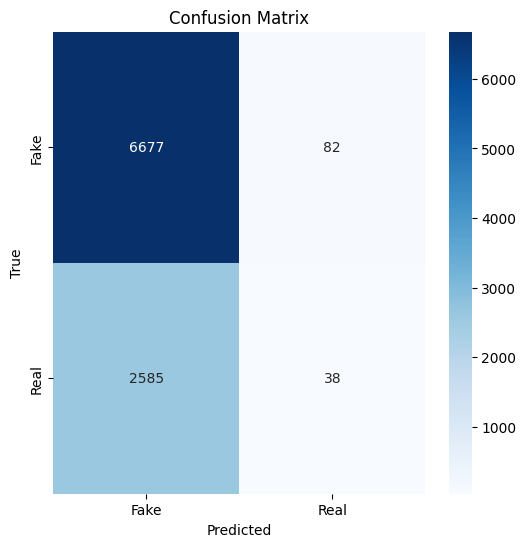

Classification Report:
              precision    recall  f1-score   support

        Fake       0.72      0.99      0.83      6759
        Real       0.32      0.01      0.03      2623

    accuracy                           0.72      9382
   macro avg       0.52      0.50      0.43      9382
weighted avg       0.61      0.72      0.61      9382



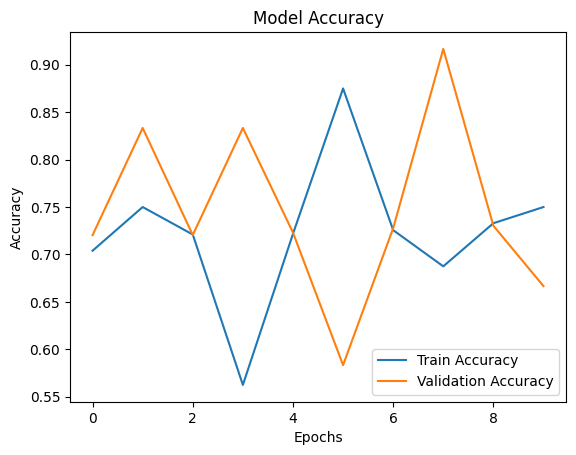

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/train'
valid_dir = '/kaggle/working/split_data/valid'
test_dir = '/kaggle/working/split_data/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# Load the pre-trained ResNet50 model without the top layer (for fine-tuning)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model layers to prevent them from being updated during training
base_model.trainable = False

# Build the new model on top of ResNet50
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/resnet50_model.h5')


## MobileNetV2

Found 15632 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.
Found 9382 images belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 75s 140ms/step - accuracy: 0.7897 - loss: 0.4529 - val_accuracy: 0.9635 - val_loss: 0.1554
Epoch 2/10
  1/488 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8750 - loss: 0.2078

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8750 - loss: 0.2078 - val_accuracy: 1.0000 - val_loss: 0.1326
Epoch 3/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.9103 - loss: 0.2224 - val_accuracy: 0.9686 - val_loss: 0.1251
Epoch 4/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 55us/step - accuracy: 0.9375 - loss: 0.2109 - val_accuracy: 1.0000 - val_loss: 0.1257
Epoch 5/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.9289 - loss: 0.1808 - val_accuracy: 0.9710 - val_loss: 0.1069
Epoch 6/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.8750 - loss: 0.2130 - val_accuracy: 1.0000 - val_loss: 0.0318
Epoch 7/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.9318 - loss: 0.1746 - val_accuracy: 0.9747 - val_loss: 0.1015
Epoch 8/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.9062 - loss: 0.1321 - val_accuracy: 1.0000 - val_loss: 0.1071
Epoch 9/10
488/488 ━━━━━━━━━━━━━━━━━━━━ 65s 131ms/step - accuracy: 0.9388 - loss: 0.1603 - val_accuracy

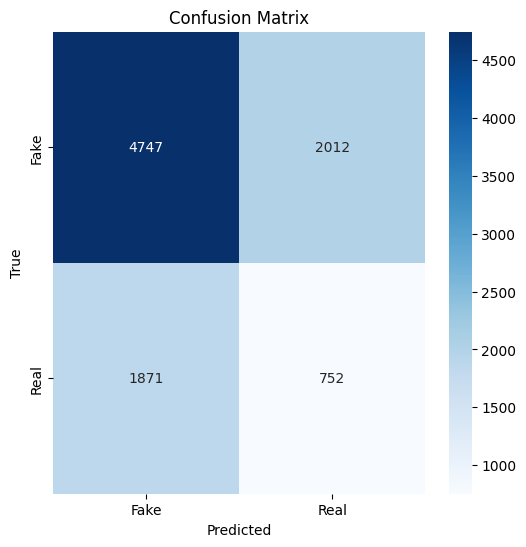

Classification Report:
              precision    recall  f1-score   support

        Fake       0.72      0.70      0.71      6759
        Real       0.27      0.29      0.28      2623

    accuracy                           0.59      9382
   macro avg       0.49      0.49      0.49      9382
weighted avg       0.59      0.59      0.59      9382



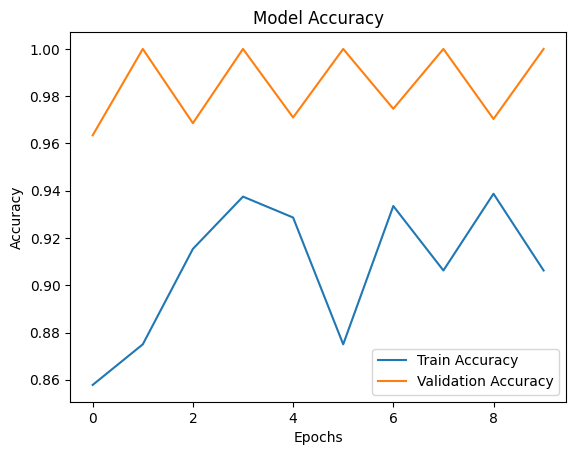

In [10]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/train'
valid_dir = '/kaggle/working/split_data/valid'
test_dir = '/kaggle/working/split_data/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# MobileNetV2 base model for transfer learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # Exclude the final classification layers
    weights='imagenet'  # Use pre-trained weights from ImageNet
)

# Freeze the base model to prevent training its layers
base_model.trainable = False

# CNN model architecture with MobileNetV2 as the base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global average pooling layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/mobile_net_model.h5')


## VGG16

Found 15632 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.
Found 9382 images belonging to 2 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


488/488 ━━━━━━━━━━━━━━━━━━━━ 73s 140ms/step - accuracy: 0.9113 - loss: 0.2073 - val_accuracy: 0.9925 - val_loss: 0.0214 - learning_rate: 1.0000e-04
Epoch 2/20
  1/488 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 1.0000 - loss: 0.0204

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0076 - learning_rate: 1.0000e-04
Epoch 3/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 65s 132ms/step - accuracy: 0.9782 - loss: 0.0614 - val_accuracy: 0.9894 - val_loss: 0.0256 - learning_rate: 1.0000e-04
Epoch 4/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 45us/step - accuracy: 0.9688 - loss: 0.0981 - val_accuracy: 1.0000 - val_loss: 9.8645e-04 - learning_rate: 1.0000e-04
Epoch 5/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 66s 133ms/step - accuracy: 0.9837 - loss: 0.0448 - val_accuracy: 0.9937 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 6/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 1.0000 - loss: 0.0130 - val_accuracy: 1.0000 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 7/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 65s 132ms/step - accuracy: 0.9877 - loss: 0.0361 - val_accuracy: 0.9947 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 8/20
488/488 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accur

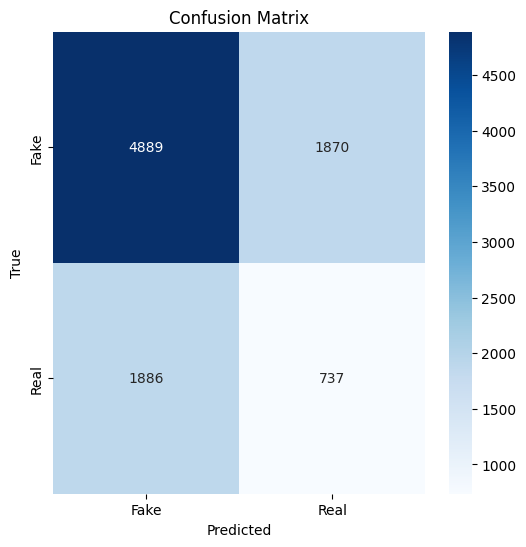

Classification Report:
              precision    recall  f1-score   support

        Fake       0.72      0.72      0.72      6759
        Real       0.28      0.28      0.28      2623

    accuracy                           0.60      9382
   macro avg       0.50      0.50      0.50      9382
weighted avg       0.60      0.60      0.60      9382



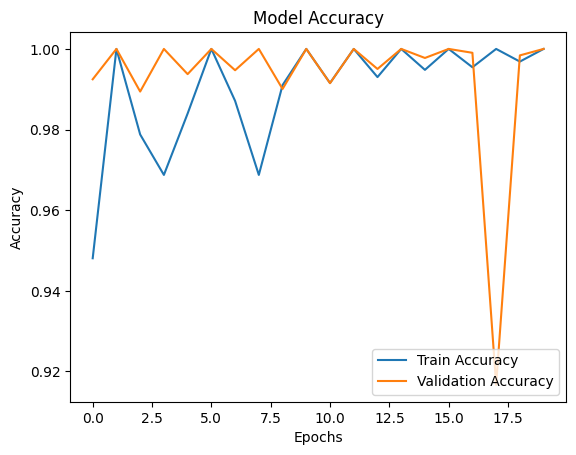

In [11]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

# Define directories for train, validation, and test datasets
train_dir = '/kaggle/working/split_data/train'
valid_dir = '/kaggle/working/split_data/valid'
test_dir = '/kaggle/working/split_data/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# Load pre-trained VGG16 model + higher level layers
vgg_base = VGG16(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))  # Exclude fully connected layers

# Unfreeze the last few layers of VGG16 for fine-tuning
for layer in vgg_base.layers[:15]:  # Freeze the first 15 layers
    layer.trainable = False
for layer in vgg_base.layers[15:]:  # Unfreeze the rest
    layer.trainable = True

# Create the model
model = models.Sequential([
    vgg_base,  # Add the VGG16 convolutional base
    layers.GlobalAveragePooling2D(),  # Global average pooling instead of Flatten for better performance
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Use ReduceLROnPlateau to reduce the learning rate if the validation accuracy plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Increased the number of epochs
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32,
    callbacks=[lr_scheduler]
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/vgg16_fine_tuned_model.h5')


## kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define the directory paths for train, validation, and test datasets
train_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train'
valid_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid'
test_dir = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test'

# Define image size
IMG_SIZE = 128  # Resize images to 128x128

# Data augmentation and preprocessing for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images in batches for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'  # binary labels for real and fake
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary'
)

# CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification (Real vs Fake)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Binary classification loss
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=valid_generator.samples // 32
)

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // 32)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Confusion Matrix
test_generator.reset()  # Reset the test generator to ensure the full dataset is used
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))

# Accuracy Plot (Training and Validation Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model if needed
model.save('/kaggle/working/cnn_model.h5')


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2962/3125 ━━━━━━━━━━━━━━━━━━━━ 1:10 431ms/step - accuracy: 0.5436 - loss: 0.6855